## Лабораторная 
## Исследование kNN

In [41]:
import numpy as np
import pandas
from matplotlib import pyplot
from sklearn.decomposition import PCA
import scipy as sp
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
import csv
#%pylab inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Загрузим 40 элементов обучающей выборки для визуализации:

In [3]:
X = (np.loadtxt('hard_train.txt'))[:40]

In [4]:
print(X.shape)

(40, 784)


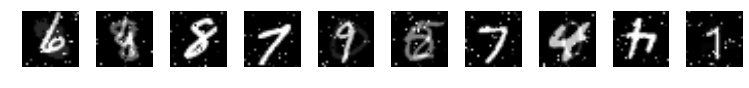

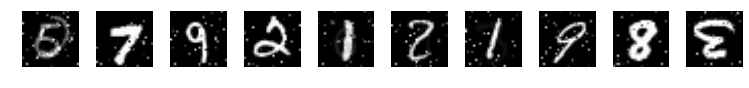

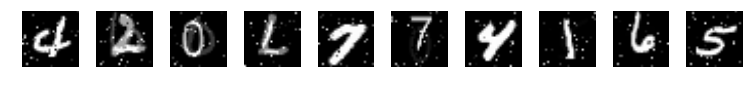

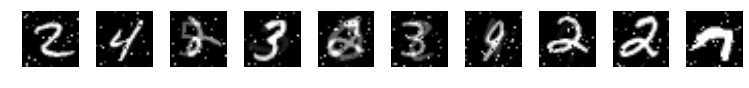

In [9]:
for i in range(4):
    pyplot.figure(figsize=(13, 1))
    
    for j in range(10):
        pyplot.subplot(1, 10, j + 1)
        pyplot.imshow(X[i * 10 + j].reshape((28, 28)), cmap='gray')
        pyplot.axis('off')
    
    pyplot.show()

### Разбиение выборки:

Загрузим обучающую выборку:

In [29]:
hard_train = np.loadtxt('hard_train.txt')
hard_train_labels = np.loadtxt('hard_train_labels.txt')

Функция, которая blocks_number раз разбивает выборку на части размеров ${2 · 10^3, 4 · 10^3, \dots, samples\_number \cdot 2 · 10^3, 10^4}$ случайно перемешивая выборку и извлекая непересекающиеся блоки последовательных элементов указанных размеров:

In [30]:
samples = list(zip(hard_train, hard_train_labels))

def getShuffledSamples(blocks_number, samples_number):
    shuffledSamples = [[() for j in range(samples_number)] for i in range(blocks_number)]
    
    for i in range(blocks_number):
        random.shuffle(samples)
        sample_begin_index = 0
        
        X_shuffled = list(map(lambda x: x[0], samples))
        y_shuffled = list(map(lambda x: x[1], samples))
        
        X_test = (X_shuffled)[100000 : 101000]
        y_test = (y_shuffled)[100000 : 101000]
    
        for j in range(samples_number):
            sample_end_index = sample_begin_index + 2000 * (j + 1)
        
            X_train = (X_shuffled)[sample_begin_index : sample_end_index]
            y_train = (y_shuffled)[sample_begin_index : sample_end_index]
        
            shuffledSamples[i][j] = [X_train, y_train, X_test, y_test]
            
    return shuffledSamples

Запустим функцию выше с blocks_number=5, samples_number=5. Получим 5 блоков по 5 выборок нужных размеров:

In [31]:
shuffledSamples = getShuffledSamples(5, 5)

### Запуск knn для разных размеров выборок и разных k:

Функция, которая обучает knn на X_train, y_train, запускает его на  X_test, 
считает время работы и accuracy на y_test. 
И это все для $k \in \{1, \dots, 20\}$. Возвращает список точностей и список времен для k на данной выборке:

In [12]:
def processSample(X_train, y_train, X_test, y_test):
    accuracy = []
    time = []
    
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        start = datetime.now()
        
        knn.fit(X_train, y_train)        
        y_predicted = knn.predict(X_test)
        
        end = datetime.now()
        
        k_accuracy = accuracy_score(y_test, y_predicted)
        accuracy.append(k_accuracy)
        time.append((end - start).total_seconds())
        
    return accuracy, time

Запустим теперь processSample на каждой из выборок из shuffledSamples. Результат сохраним в списки точностей
accuracies и список времен times:

In [16]:
accuracies = [[] for i in range(5)]
times = [[] for i in range(5)]

for j in range(0, 5):
    obtained_accuracy = [(0, 0) for i in range(5)]
    obtained_time = [(0, 0) for i in range(5)]
    for i in range(0, 5):   
        
        X_train = shuffledSamples[i][j][0]
        y_train = shuffledSamples[i][j][1]
        X_test = shuffledSamples[i][j][2]
        y_test = shuffledSamples[i][j][3]
        
        accuracy, time = processSample(X_train, y_train, X_test, y_test)
        obtained_accuracy[i] = accuracy 
        obtained_time[i] = time
    
    accuracy = [obtained_accuracy[i] for i in range(5)]
    time = [obtained_time[i] for i in range(5)]

    accuracies[j] = list(zip(*accuracy))
    times[j] = list(zip(*time)) 
    

Усредним значения accuracy и time по пяти независимым выборкам:

In [26]:
mean_accuracies = [[0 for i in range(20)] for j in range(5)]
mean_times = [[0 for i in range(20)] for j in range(5)]

for i in range(5):
    for j in range(20):
        mean_accuracies[i][j] = np.mean(accuracies[i][j])
        mean_times[i][j] = np.mean(times[i][j])

### Графики зависимости accuracy  от k (количества соседей) и и time от размера выборки:

Графики зависимостей time от размера выборки построим для нечетных k. Для этого построим список times_k,
где для четных i times_k$[i / 2][j]$ есть время работы на выборке размера $2000 \cdot (j + 1)$  :

In [20]:
times_k = [[] for i in range(10)]
for j in range(10):
    times_k[j] = [mean_times[i][j * 2 + 1] for i in range(5)]

In [21]:
def showAccuracy(items_number, accuracy):
    pyplot.plot(range(1, 21), accuracy)
    
    pyplot.title('Accuracy depending on k')
    pyplot.xlabel('Neighbours number')
    pyplot.ylabel('Accuracy')
    

def showTime(time_k, k):
    pyplot.plot(range(2000, 11000, 2000), time_k)
    
    pyplot.title('Time depending on sample size on k=%d' % (k))
    pyplot.xlabel('Sample size')
    pyplot.ylabel('Time spent')

#### Графики зависимостей accuracy от k:

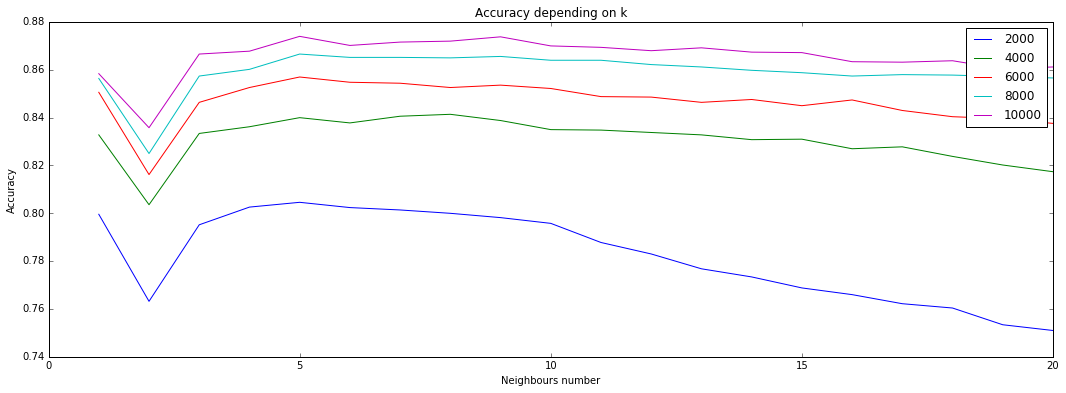

In [40]:
pyplot.figure(figsize=(18, 6))
for i in range(5):
    showAccuracy((i+1) * 2000, mean_accuracies[i])

pyplot.legend(['2000', '4000', '6000', '8000', '10000'])
pyplot.show()

Как видно, при k=2 действительно получается результат намного хуже, чем при $k \in \{1, 3, 4, 5\}$. Это может быть связано с тем, что knn при k=2 хорошо классифицирует только если оба соседа точки относятся к одному классу (когда одна из двух точек относится к одному классу, а вторая -- к другому, алгоритм "не уверен" в ответе), когда как при k=1 или k=3 классификация уверенная когда 1/1 или 2/3, 3/3 точек соответственно относятся к одному классу. Последнее случается горазо чаще, чем первое, поэтому качество классификации при k=1 или k=3 выше.

Графики зависимостей time от размера выборки:

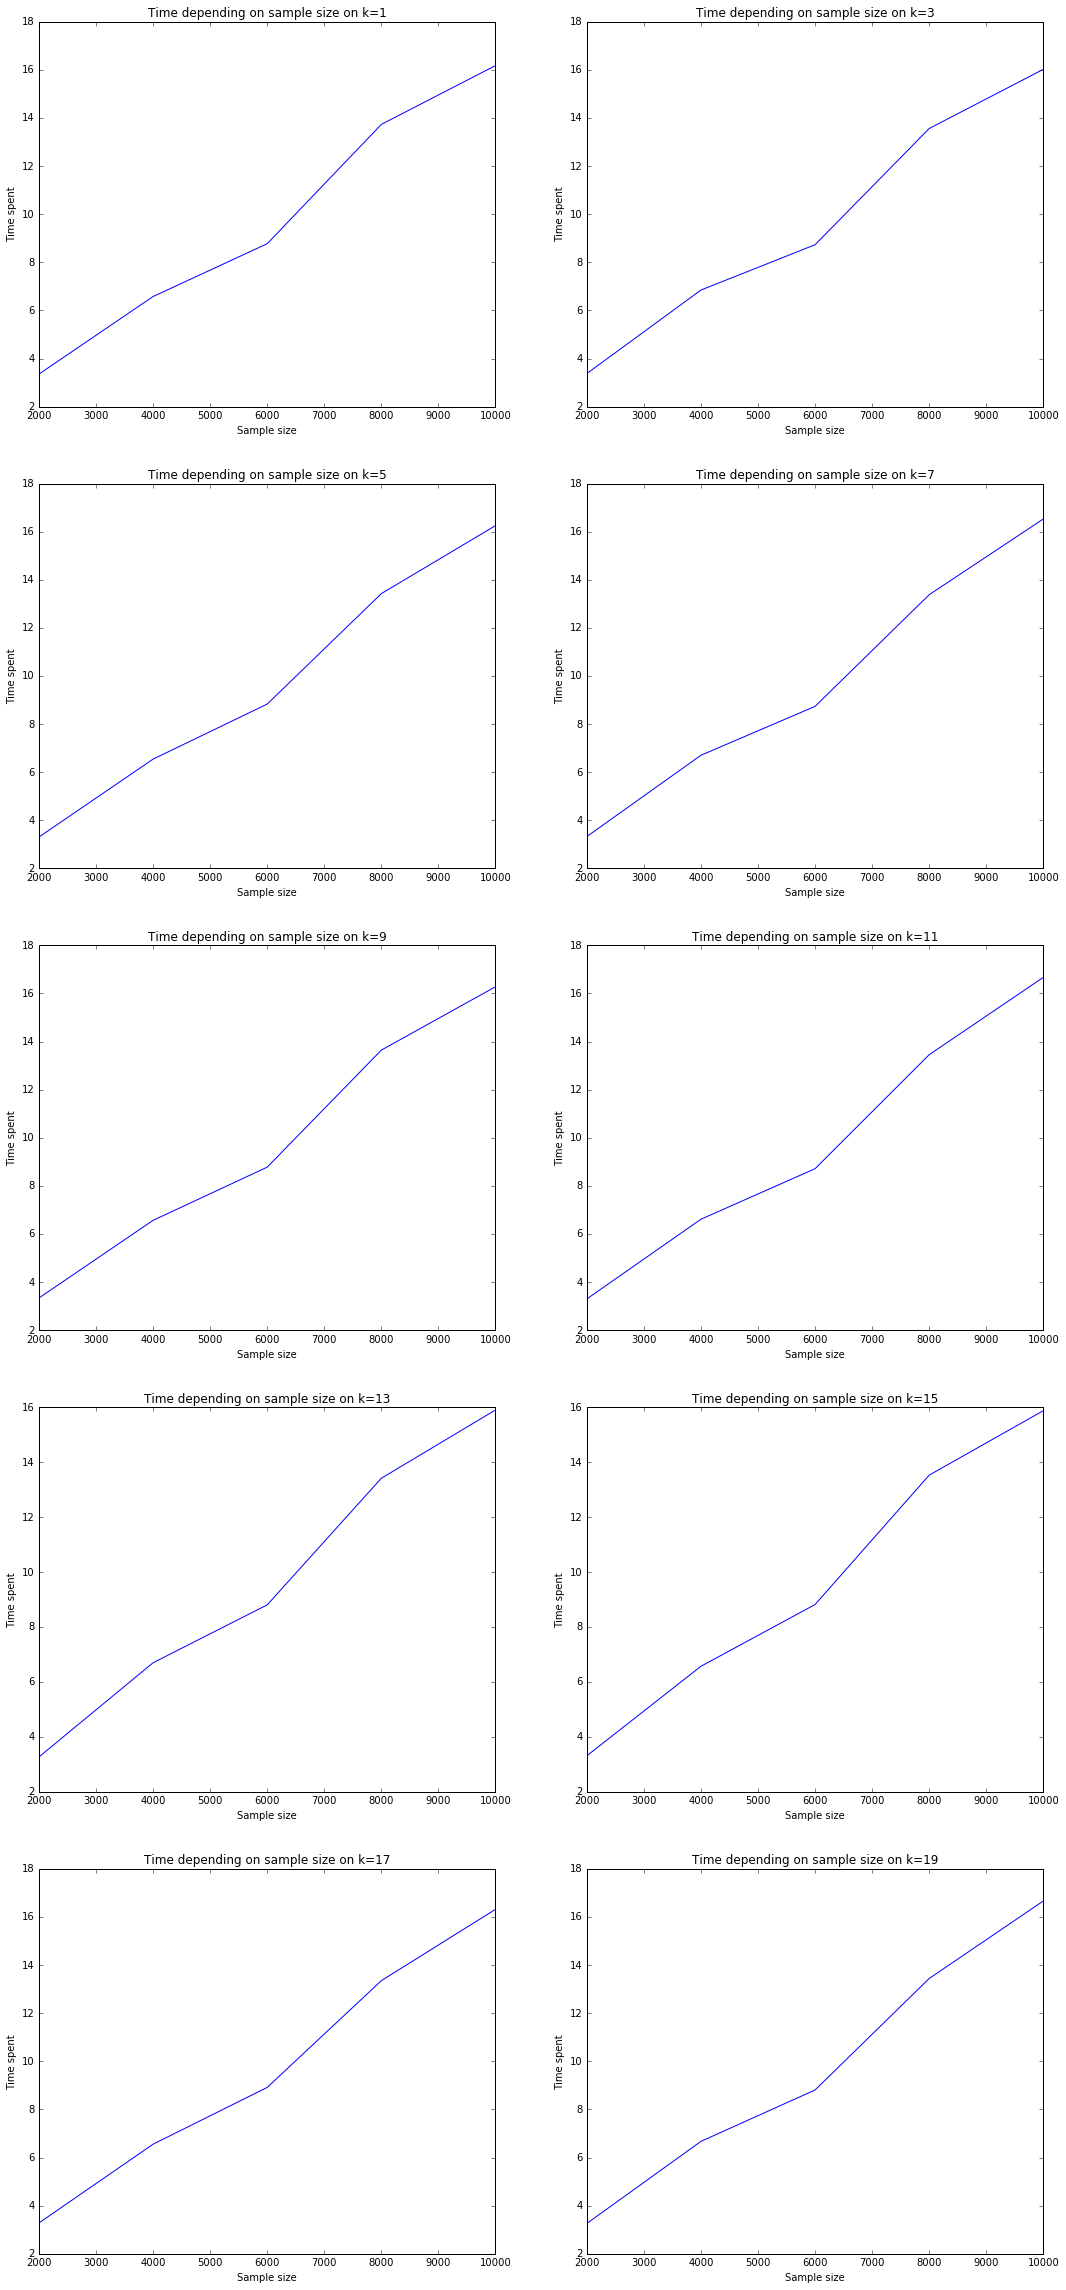

In [24]:
pyplot.figure(figsize=(18, 40))
for i in range(10):
    pyplot.subplot(5, 2, i + 1)
    showTime(times_k[i], i * 2 + 1)

pyplot.show()

### Лучшее k:

In [25]:
for i in range(5):
    best_k = 0
    best_accuracy = 0
    for j in range(20):
        if mean_accuracies[i][j] > best_accuracy:
            best_k = j + 1
            best_accuracy = mean_accuracies[i][j]
    
    print 'Sample size:', (i + 1) * 2000
    print 'best k:', best_k
    print 'accuracy:', best_accuracy
    print 

Sample size: 2000
best k: 5
accuracy: 0.8046

Sample size: 4000
best k: 8
accuracy: 0.8414

Sample size: 6000
best k: 5
accuracy: 0.857

Sample size: 8000
best k: 5
accuracy: 0.8666

Sample size: 10000
best k: 5
accuracy: 0.874



Итак, лучшее k=5 (для Sample size: 4000 при k=5 accuracy почти то же, что для k=8)

Обучим knn на выборке размера 10000 с k=5:

In [32]:
X_train = shuffledSamples[0][4][0]
y_train = shuffledSamples[0][4][1]
X_test = shuffledSamples[0][4][2]
y_test = shuffledSamples[0][4][3]

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)

Построим матрицу ошибок по y_predicted b y_test и визуализируем ее:

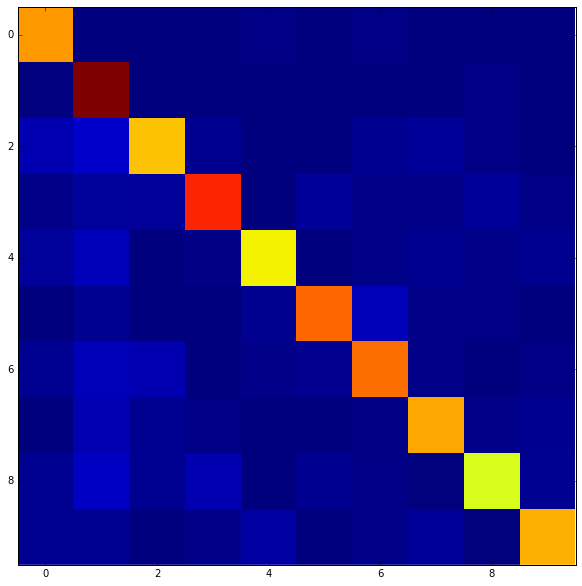

In [37]:
confusion_matrix(y_test, y_predicted)

pyplot.figure(figsize=(10, 10))
pyplot.imshow(errors, interpolation='none')
pyplot.show()